# Proyek Analisis Data: E-Commerce Public Dataset
## Nama : Athallah Azhar Aulia Hadi

Berdasarkan dataset yang tersedia, berikut adalah pertanyaan bisnis yang akan dijawab dalam analisis ini:
1. Bagaimana tren jumlah pesanan dan total pendapatan perusahaan dari waktu ke waktu?
2. Kategori produk apa yang memiliki angka penjualan tertinggi dan terendah?
3. Bagaimana distribusi tingkat kepuasan pelanggan berdasarkan skor ulasan?
4. Di wilayah mana letak demografi pelanggan terbanyak kita?
5. Bagaimana segmentasi pelanggan berdasarkan perilaku belanja mereka (RFM)?

# 1. Import Library
Langkah pertama adalah memanggil semua library yang dibutuhkan untuk pengolahan data tabular, manipulasi waktu, visualisasi grafik, dan pemetaan geospasial.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import geopandas as gpd
import os

pd.set_option('display.max_rows', None)

# 2. Data Wrangling
## 2.1 Gathering Data
Memuat seluruh dataset mentah ke dalam format DataFrame agar siap diolah.

In [28]:
customers = pd.read_csv('./Data/customers_dataset.csv')
geolocation = pd.read_csv('./Data/geolocation_dataset.csv')
order_items = pd.read_csv('./Data/order_items_dataset.csv')
order_payments = pd.read_csv('./Data/order_payments_dataset.csv')
order_reviews = pd.read_csv('./Data/order_reviews_dataset.csv')
orders = pd.read_csv('./Data/orders_dataset.csv')
product_category = pd.read_csv('./Data/product_category_name_translation.csv')
products = pd.read_csv('./Data/products_dataset.csv')
sellers = pd.read_csv('./Data/sellers_dataset.csv')

# 3. Data Cleaning
## 3.1 Filter Data Transaksi Awal
Sebelum menggabungkan tabel, kita memfilter data `orders` untuk mengambil transaksi yang berstatus 'delivered' saja. Ini mencegah perhitungan pendapatan semu dari pesanan yang batal.

In [29]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')
orders_delivered = orders[orders['order_status'] == 'delivered']

## 3.2 Merging Data Utama (Tanpa Geolocation)
Menggabungkan tabel pesanan, pelanggan, item, ulasan, dan produk. Data geolokasi sengaja tidak digabung di awal untuk mencegah lonjakan penggunaan memori akibat duplikasi titik koordinat. Baris tanpa harga juga dihapus karena tidak bernilai untuk analisis pendapatan.

In [30]:
df_transactions = pd.merge(orders_delivered, customers, on='customer_id', how='left')
df_transactions = pd.merge(df_transactions, order_items, on='order_id', how='left')
df_transactions = pd.merge(df_transactions, order_reviews, on='order_id', how='left')
df_transactions = pd.merge(df_transactions, products, on='product_id', how='left')

df_transactions.dropna(subset=['price'], inplace=True)

## 3.3 Translasi Kategori Produk
Mengubah nama kategori produk dari bahasa Portugis ke bahasa Inggris agar lebih mudah dipahami, serta menangani nilai kosong pada kategori.

In [31]:
mapping = dict(zip(product_category['product_category_name'], product_category['product_category_name_english']))
df_transactions['product_category_name'] = df_transactions['product_category_name'].map(mapping).fillna(df_transactions['product_category_name'])

mapping_spesifik = {'portateis_cozinha_e_preparadores_de_alimentos': 'kitchen_portables_and_food_preparators'}
df_transactions['product_category_name'] = df_transactions['product_category_name'].replace(mapping_spesifik).fillna('others')

## 3.4 Merging Data Geolocation
Setelah data transaksi ramping dan bersih, kita menggabungkannya dengan tabel geolokasi menggunakan referensi kode pos pelanggan. Kita juga langsung membuang kolom yang tidak relevan untuk mengoptimalkan kinerja sistem.

In [32]:
df_complete = pd.merge(
    df_transactions, 
    geolocation, 
    left_on='customer_zip_code_prefix', 
    right_on='geolocation_zip_code_prefix', 
    how='left'
).drop(columns=['geolocation_zip_code_prefix'])

kolom_penting = [
    'order_id', 'customer_unique_id', 'order_status', 'order_purchase_timestamp', 
    'price', 'product_category_name', 'customer_city', 'customer_state', 
    'geolocation_lat', 'geolocation_lng', 'review_score'
]
df_clean = df_complete[kolom_penting].copy()

print(f"Bentuk data final siap analisis: {df_clean.shape}")

Bentuk data final siap analisis: (16940952, 11)


In [34]:
kolom_downsize = df_clean.select_dtypes(include=['int64', 'float64'])
for col in kolom_downsize.columns:
    if pd.api.types.is_integer_dtype(df_clean[col]):
        df_clean[col] = df_clean[col].astype('int32')
    elif pd.api.types.is_float_dtype(df_clean[col]):
        df_clean[col] = df_clean[col].astype('float16')

In [35]:
df_clean.to_parquet('./Dashboard/ecommerce_cleaned.parquet', index=False)

# 4. Exploratory Data Analysis (EDA) & Visualization
## 4.1 Tren Pesanan dan Pendapatan Bulanan
Saya mengekstrak bulan dan tahun dari waktu pembelian. Duplikasi `order_id` dan *item* dihapus lebih dulu agar perhitungan total pesanan dan pendapatan (*revenue*) tidak terhitung ganda akibat proses *merge* geolokasi sebelumnya.

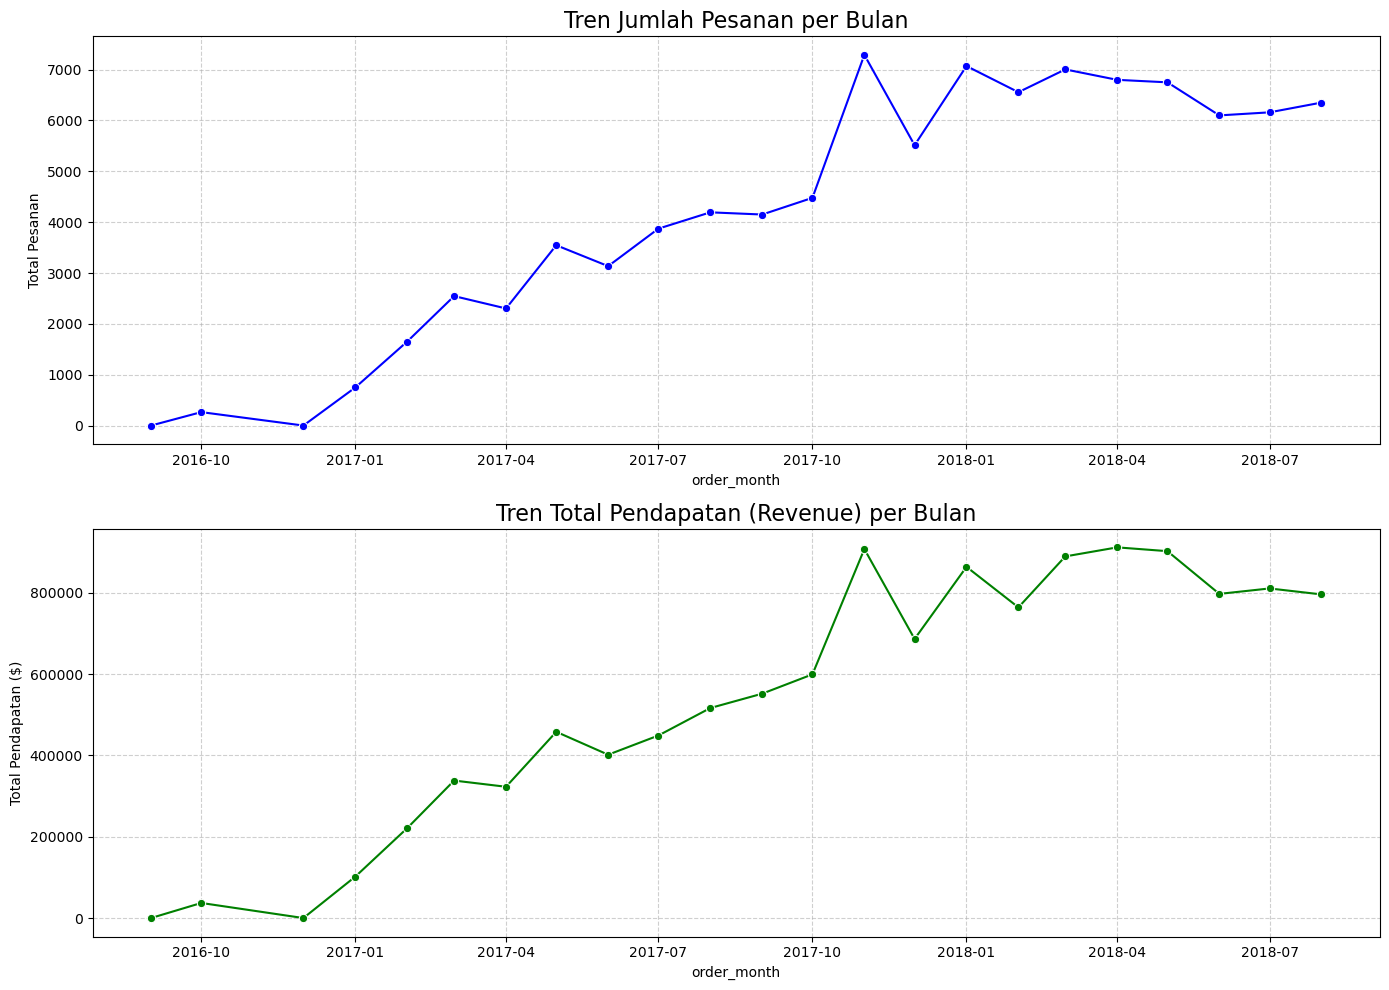

In [36]:
df_clean['order_month'] = df_clean['order_purchase_timestamp'].dt.to_period('M')

# Hitung Pesanan Unik
df_orders_unique = df_clean.drop_duplicates(subset=['order_id'])
tren_pesanan = df_orders_unique.groupby('order_month').size().reset_index(name='total_pesanan')
tren_pesanan['order_month'] = tren_pesanan['order_month'].dt.to_timestamp()

# Hitung Pendapatan Unik
df_items_unique = df_clean.drop_duplicates(subset=['order_id', 'price', 'product_category_name'])
tren_pendapatan = df_items_unique.groupby('order_month')['price'].sum().reset_index(name='total_pendapatan')
tren_pendapatan['order_month'] = tren_pendapatan['order_month'].dt.to_timestamp()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

sns.lineplot(x='order_month', y='total_pesanan', data=tren_pesanan, marker='o', ax=ax[0], color='blue')
ax[0].set_title('Tren Jumlah Pesanan per Bulan', fontsize=16)
ax[0].set_ylabel('Total Pesanan')
ax[0].grid(True, linestyle='--', alpha=0.6)

sns.lineplot(x='order_month', y='total_pendapatan', data=tren_pendapatan, marker='o', ax=ax[1], color='green')
ax[1].set_title('Tren Total Pendapatan (Revenue) per Bulan', fontsize=16)
ax[1].set_ylabel('Total Pendapatan ($)')
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Insight:**
Volume pesanan dan pendapatan bulanan memiliki korelasi positif yang kuat. Terdapat tren kenaikan penjualan yang signifikan pada paruh kedua tahun ini, mencapai puncaknya pada bulan November yang kemungkinan besar didorong oleh momentum promosi *Black Friday*.

## 4.2 Kategori Produk Paling Laris dan Paling Sepi
Menghitung frekuensi penjualan setiap kategori menggunakan data *item* unik, lalu memvisualisasikan 10 kategori teratas dan 10 kategori terbawah.

C:\Users\Gateway\AppData\Local\Temp\ipykernel_17364\4142228243.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_sales', y='product_category_name', data=top_10, palette='viridis', ax=ax[0])
C:\Users\Gateway\AppData\Local\Temp\ipykernel_17364\4142228243.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_sales', y='product_category_name', data=bottom_10, palette='magma', ax=ax[1])


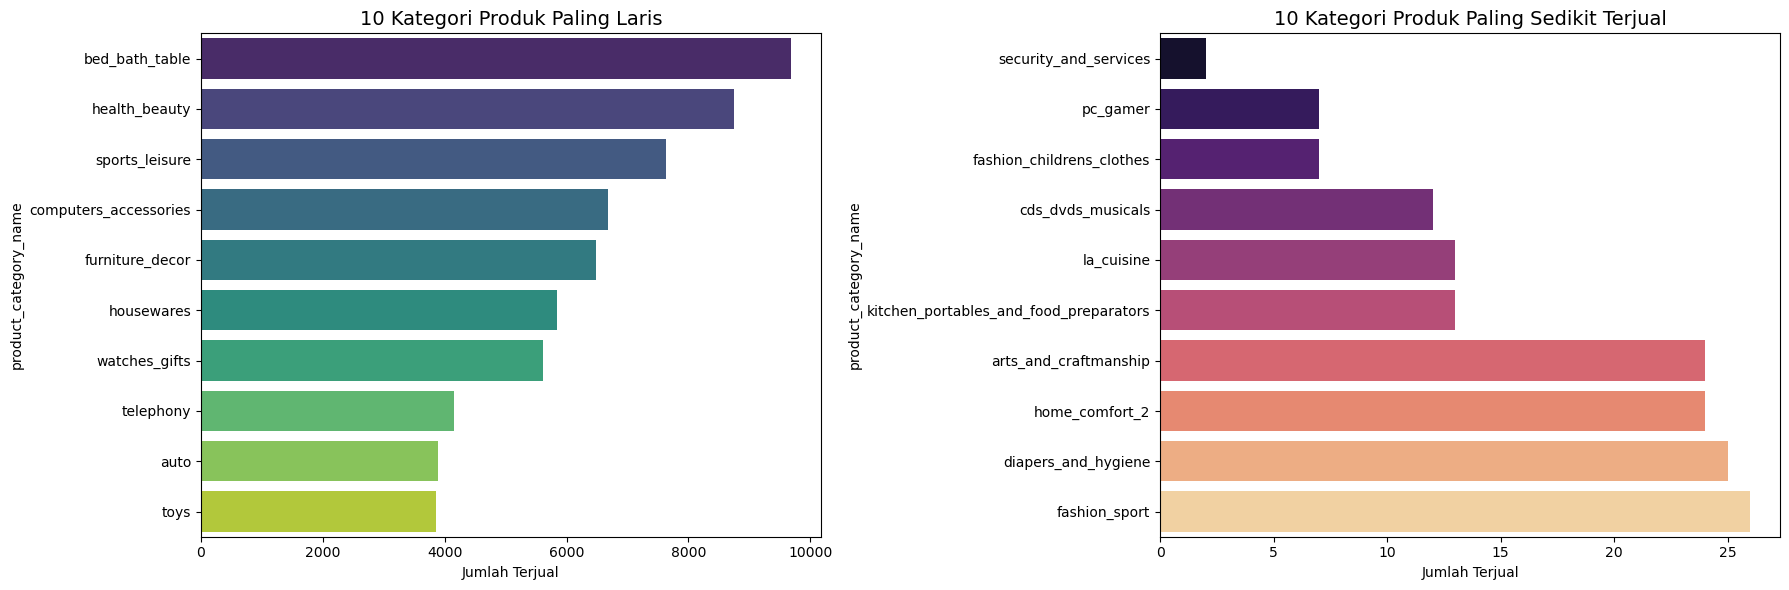

In [37]:
kategori_penjualan = df_items_unique['product_category_name'].value_counts().reset_index()
kategori_penjualan.columns = ['product_category_name', 'total_sales']

top_10 = kategori_penjualan.head(10)
bottom_10 = kategori_penjualan.tail(10).sort_values(by='total_sales', ascending=True)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.barplot(x='total_sales', y='product_category_name', data=top_10, palette='viridis', ax=ax[0])
ax[0].set_title('10 Kategori Produk Paling Laris', fontsize=14)
ax[0].set_xlabel('Jumlah Terjual')

sns.barplot(x='total_sales', y='product_category_name', data=bottom_10, palette='magma', ax=ax[1])
ax[1].set_title('10 Kategori Produk Paling Sedikit Terjual', fontsize=14)
ax[1].set_xlabel('Jumlah Terjual')

plt.tight_layout()
plt.show()

**Insight:**
Kategori `bed_bath_table`, `health_beauty`, dan `sports_leisure` adalah tulang punggung pendapatan perusahaan. Sebaliknya, kategori khusus atau teknis seperti `security_and_services` dan `fashion_childrens_clothes` sangat minim transaksi. Strategi inventaris harus memprioritaskan penyediaan stok pada kategori top 10.

## 4.3 Distribusi Tingkat Kepuasan Pelanggan
Membersihkan data ulasan dari nilai kosong (`NaN`) dan memastikan satu pesanan hanya menyumbang satu skor ulasan. Visualisasi menggunakan *bar chart* untuk melihat sentimen dominan.

C:\Users\Gateway\AppData\Local\Temp\ipykernel_17364\4048736651.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='review_score', y='total', data=distribusi_review, palette='coolwarm')


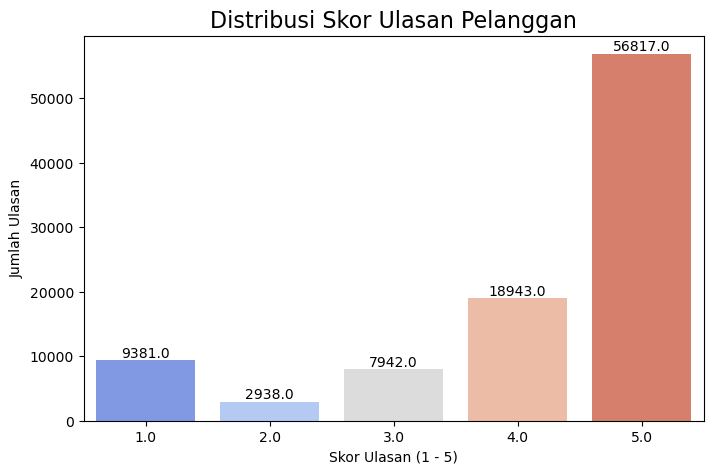

In [38]:
df_reviews = df_clean.dropna(subset=['review_score']).drop_duplicates(subset=['order_id', 'review_score'])
distribusi_review = df_reviews['review_score'].value_counts().sort_index().reset_index()
distribusi_review.columns = ['review_score', 'total']

plt.figure(figsize=(8, 5))
sns.barplot(x='review_score', y='total', data=distribusi_review, palette='coolwarm')
plt.title('Distribusi Skor Ulasan Pelanggan', fontsize=16)
plt.xlabel('Skor Ulasan (1 - 5)')
plt.ylabel('Jumlah Ulasan')

for index, row in distribusi_review.iterrows():
    plt.text(row.name, row.total + 500, f"{row.total}", color='black', ha="center")

plt.show()

**Insight:**
Mayoritas pelanggan merasa sangat puas, terindikasi dari lonjakan drastis pada skor 5 dan 4. Namun, jumlah skor 1 menempati urutan ketiga terbanyak, mengisyaratkan adanya isu fundamental yang dirasakan sebagian pelanggan (kemungkinan terkait keterlambatan logistik atau barang cacat) yang memerlukan evaluasi tim layanan pelanggan.

## 4.4 Analisis Geospasial: Persebaran Demografi Pelanggan
Memetakan koordinat *latitude* dan *longitude* pelanggan ke dalam plot visual. Batas koordinat disetel khusus untuk wilayah negara Brazil guna membuang data pencilan (*outliers*) yang merusak tampilan peta.

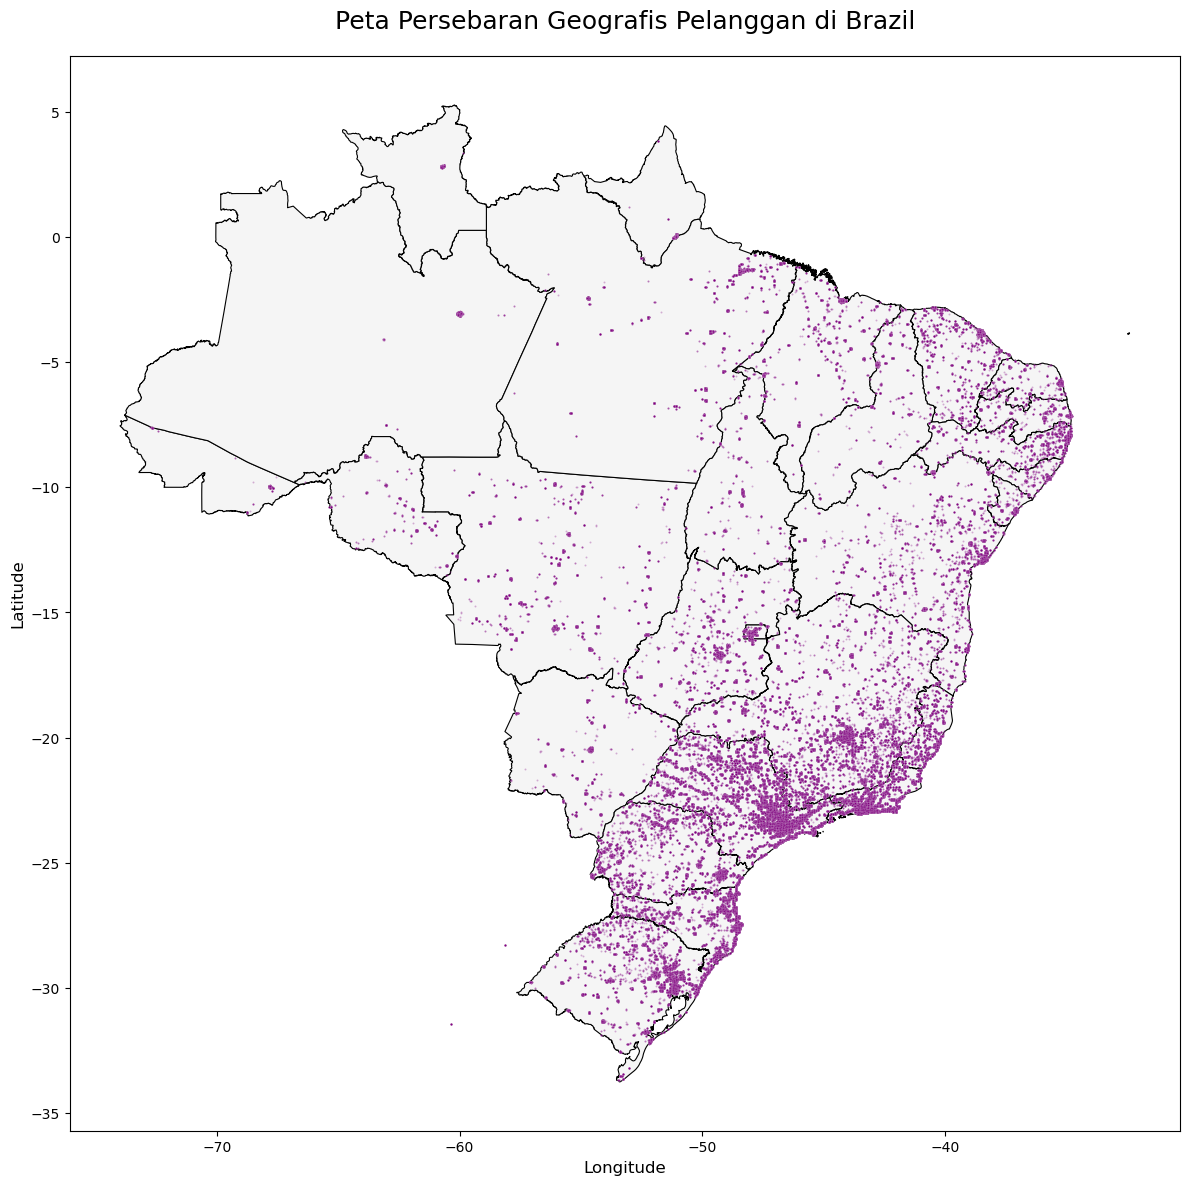

In [39]:
df_geo = df_clean.drop_duplicates(subset=['customer_unique_id', 'geolocation_lat', 'geolocation_lng'])

bbox = [
    df_geo['geolocation_lng'].between(-73.9828, -34.7931),
    df_geo['geolocation_lat'].between(-33.7511, 5.2743)
]
df_geo_brazil = df_geo[bbox[0] & bbox[1]]

try:
    url_brazil_states = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
    brazil_map = gpd.read_file(url_brazil_states)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    brazil_map.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=0.8)
    
    sns.scatterplot(x='geolocation_lng', y='geolocation_lat', data=df_geo_brazil, 
                    alpha=0.3, s=2, color='purple', ax=ax)
    
    ax.set_title('Peta Persebaran Geografis Pelanggan di Brazil', fontsize=18, pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    ax.grid(False) 
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Gagal memuat peta dasar: {e}")
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='geolocation_lng', y='geolocation_lat', data=df_geo_brazil, alpha=0.3, s=2, color='purple')
    plt.title('Peta Persebaran Geografis Pelanggan (Scatter Only)', fontsize=16)
    plt.show()

**Insight:**
Titik demografi pelanggan sangat pekat di kawasan tenggara dan selatan Brazil (terutama di sekitar São Paulo dan Rio de Janeiro). Distribusi logistik dan strategi pemasaran regional harus difokuskan di area padat ini untuk meminimalisasi biaya pengiriman.

## 4.5 Segmentasi Pelanggan (RFM Analysis)
Mengkategorikan pelanggan berdasarkan metrik *Recency* (kapan terakhir transaksi), *Frequency* (jumlah transaksi), dan *Monetary* (total pengeluaran). Perhitungan uang mutlak menggunakan `df_items_unique` agar nilainya tidak berlipat ganda.

C:\Users\Gateway\AppData\Local\Temp\ipykernel_17364\2501182542.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segmen_counts, x='Total', y='Segment', palette='Set2')


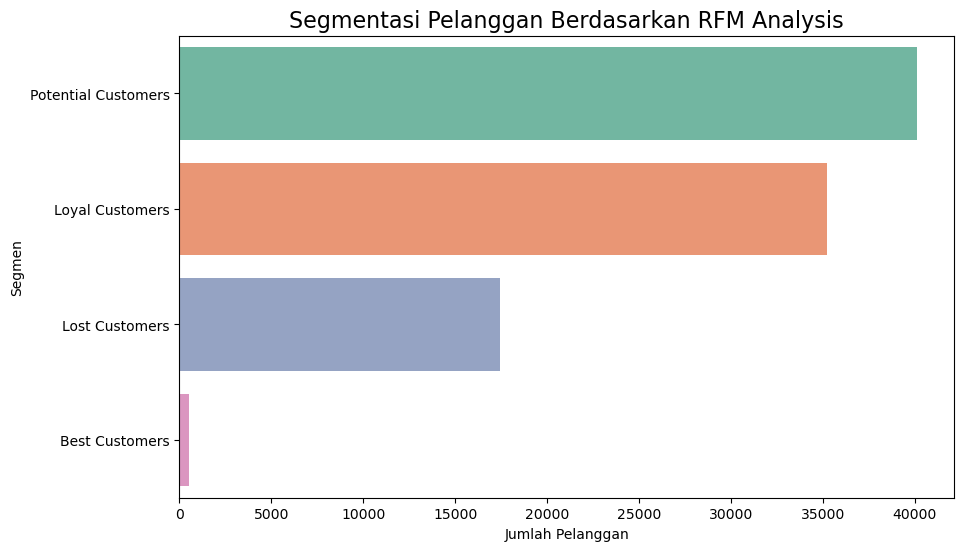

In [40]:
tanggal_sekarang = df_items_unique['order_purchase_timestamp'].max() + dt.timedelta(days=1)

rfm = df_items_unique.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (tanggal_sekarang - x.max()).days,
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()

rfm.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

rfm['r_rank'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm['m_rank'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)
rfm['f_rank'] = rfm['Frequency'].apply(lambda x: 4 if x > 3 else (3 if x > 2 else (2 if x > 1 else 1)))

rfm['RFM_Total'] = rfm[['r_rank','f_rank','m_rank']].sum(axis=1)

def segment_customer(score):
    if score >= 10: return 'Best Customers'
    elif score >= 7: return 'Loyal Customers'
    elif score >= 5: return 'Potential Customers'
    else: return 'Lost Customers'

rfm['Segment'] = rfm['RFM_Total'].apply(segment_customer)

segmen_counts = rfm['Segment'].value_counts().reset_index()
segmen_counts.columns = ['Segment', 'Total']

plt.figure(figsize=(10, 6))
sns.barplot(data=segmen_counts, x='Total', y='Segment', palette='Set2')
plt.title('Segmentasi Pelanggan Berdasarkan RFM Analysis', fontsize=16)
plt.xlabel('Jumlah Pelanggan')
plt.ylabel('Segmen')
plt.show()

**Insight:**
Berdasarkan analisis RFM, basis pelanggan saat ini didominasi oleh segmen **Potential Customers** di peringkat pertama, disusul oleh **Loyal Customers** di peringkat kedua. Ini menunjukkan fundamental pelanggan aktif yang baik dan punya peluang besar untuk terus tumbuh. Walau begitu, kehadiran **Lost Customers** di peringkat ketiga tetap perlu diperhatikan. Perusahaan bisa menjalankan kampanye reaktivasi atau memberi penawaran khusus (seperti kupon diskon) untuk menarik kembali pelanggan lama yang sudah lama tidak berbelanja.

# 5. Conclusion
Penyelesaian masalah bisnis berdasarkan analisis data di atas:
1. **Tren Bisnis:** Penjualan stabil dengan tren peningkatan yang berpuncak pada bulan November. Pola ini bisa diantisipasi ke depannya dengan menyiapkan kapasitas server dan kesiapan logistik di kuartal empat.
2. **Kinerja Produk:** Fokuskan anggaran inventaris dan pemasaran pada barang rumah tangga (*bed_bath_table*) serta kecantikan. Hindari menyetok produk dari kategori dengan performa buruk.
3. **Kualitas Layanan:** Secara keseluruhan sangat baik (didominasi ulasan bintang 5). Evaluasi khusus diperlukan untuk menangani penyebab ulasan bintang 1 agar tidak menggerus reputasi merek.
4. **Logistik Geografis:** Bangun pusat distribusi atau gudang (*warehouse*) utama di area tenggara Brazil (São Paulo) untuk mempercepat pengiriman, karena wilayah inilah yang menghasilkan pesanan terbanyak.
5. **Strategi Pelanggan:** Mayoritas basis pengguna kita saat ini berada pada segmen **"Potential Customers"** dan **"Loyal Customers"**. Ini adalah sinyal yang sangat positif. Namun, jumlah "Lost Customers" yang menempati urutan ketiga tetap harus diwaspadai. Perusahaan harus menerapkan strategi *Customer Relationship Management* (CRM) yang proaktif, seperti diskon personalisasi untuk *Potential Customers* agar segera bertransaksi lagi, dan program loyalitas eksklusif untuk mempertahankan *Loyal Customers*.